# SDM-PSI simulations from Albajes-Eizagirre et al. (2019) supplement

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



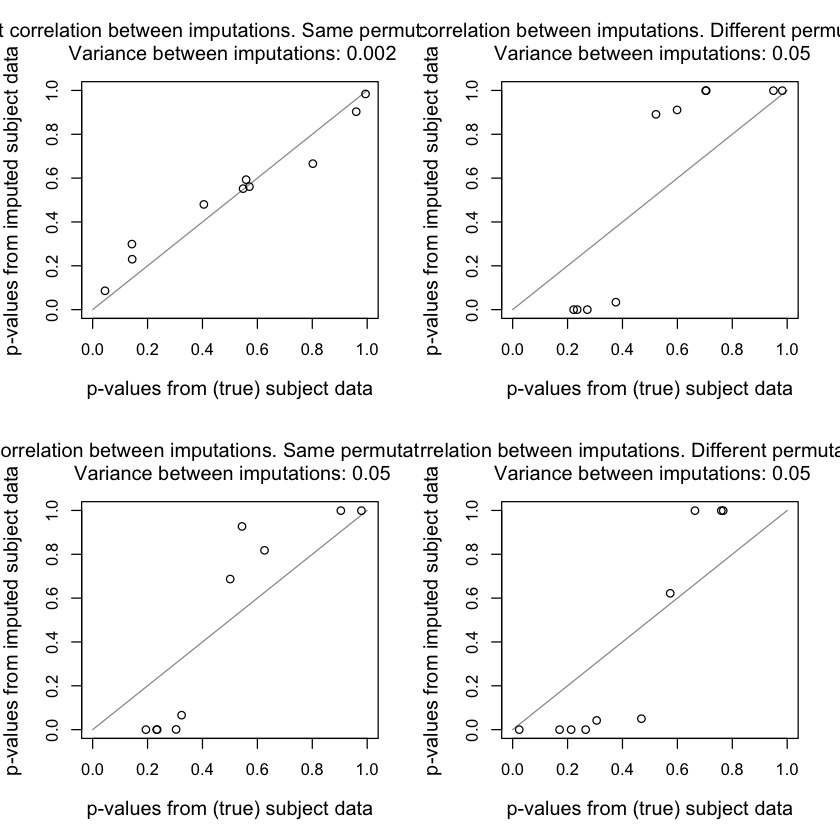

In [1]:
#################################################################################
#         EFFECTS OF THE CORRELATION BETWEEN IMPUTATIONS AND THE USE OF         #
#           VARIABLE PERMUTATION CODES IN THE STATISTICAL SIGNIFICANCE          #
#        SIMULATION OF MULTIPLE IMPUTATION OF EFFECT SIZE, IMPUTATION OF        #
#             SUBJECT VALUES AND PERMUTATION TEST FOR A SINGLE STUDY            #
#################################################################################

# Simulation parameters #######################################################
n.imp <- 50 # Number of imputations
n.perm <- 1000 # Number of permutations
n.sim <- 10 # Number of simulations
n.subj <- 20 # Number of subjects per study

# Small functions #############################################################
g <- function (y) { # Calculate Hedges' g
    if (is.vector(y)) {
        return(J * mean(y) / sd(y))
    }
    J * apply(y, 2, function (y_i) {
        mean(y_i) / sd(y_i)
    })
}
g_var <- function (g) { # Variance of Hedges' g
    1 / n.subj + (1 - (df - 2) / (df * J^2)) * g^2
}
imp.subj <- function () { # Impute subject values
    y <- rnorm(n.subj)
    (y - mean(y)) / sd(y)
}
perm <- function (y, code) { # Permute subject values
    y[code] <- -1 * y[code]
    y
}
perm.code <- function () { # Create a random permutation code
    which(runif(n.subj) > 0.5)
}
combine.g <- function (g) { # Combine Hedges' g from different imputations
    mean(g)
}
combine.g_var <- function (g, g_var) { # Combine variance from different imp.
    mean(g_var) + (1 + 1 / n.imp) * var(g)
}
sim.g.imp <- function (g) { # Simulate multiple imputation of Hedges' g
    g + rnorm(n.imp, 0, 0.2)
}
sim.y.true <- function () { # Simulate (true) subject values
    rnorm(n.subj)
}

# Main ########################################################################
library(doParallel)
registerDoParallel(cores = detectCores() - 1)
par(mfrow = c(2, 2))

# Constants
df <- n.subj - 1 # Degrees of freedom
J <- gamma(df / 2) / gamma((df - 1) / 2) * sqrt(2 / df) # Hedges' correction

# Effects to test: perfect correlation between any two imputations?
for (PERFECT_CORRELATION in c(TRUE, FALSE)) {
    # Effects to test: apply the same permutation code to all imputations?
    for (SAME_PERM_CODE in c(TRUE, FALSE)) {
        # Start simulations
        sim <- do.call(rbind.data.frame, foreach (i.sim = 1:n.sim) %dopar% {

            # Simulate (true) subject data
            y.true <- sim.y.true()

            # Calculate Hedges' g
            g.true <- g(y.true)
            g_var.true <- g_var(g.true)

            # Calculate z-value
            z.true <- g.true / sqrt(g_var.true)

            # Simulate multiple imputaion of Hedges' g
            g.imp <- sim.g.imp(g.true)
            g_var.imp <- g_var(g.imp)

            # Combine imputed Hedges' g
            g.imp.combined <- combine.g(g.imp)
            g_var.imp.combined <- combine.g_var(g.imp, g_var.imp)

            # Calculate z-value of combined imputed data
            z.imp.combined <- g.imp.combined / sqrt(g_var.imp.combined)

            # Impute subject data
            replicate.d.imp <- t(replicate(n.subj, g.imp / J))
            if (PERFECT_CORRELATION) {
                common.imp.subj <- imp.subj()
                y.imp <- replicate(n.imp, common.imp.subj) + replicate.d.imp
            } else {
                y.imp <- replicate(n.imp, imp.subj()) + replicate.d.imp
            }

            # Save variance between imputations and null distributions of z-values
            var.g.imp <- var(g.imp)
            nd.z.true <- z.true
            nd.z.imp.combined <- z.imp.combined

            for (i.perm in 1:(n.perm - 1)) {

                # Permute (true) subject data
                y.true.perm <- perm(y.true, perm.code())
                # Calculate Hedges' g of permuted data
                g.true.perm <- g(y.true.perm)
                g_var.true.perm <- g_var(g.true.perm)
                # Calculate z-value of permuted data
                z.true.perm <- g.true.perm / sqrt(g_var.true.perm)
                # Permute imputed subject data
                if (SAME_PERM_CODE) {
                    common.perm.code <- perm.code()
                    y.imp.perm <- apply(y.imp, 2, function (y.imp.i) {
                        perm(y.imp.i, common.perm.code)
                    })
                } else {
                    y.imp.perm <- apply(y.imp, 2, function (y.imp.i) {
                        perm(y.imp.i, perm.code())
                    })
                }

                # Calculate Hedges' g of permuted imputed data
                g.imp.perm <- g(y.imp.perm)
                g_var.imp.perm <- g_var(g.imp.perm)

                # Calculate z-value of permuted imputed data
                g.imp.perm.combined <- combine.g(g.imp.perm)
                g_var.imp.perm.combined <- combine.g_var(g.imp.perm, g_var.imp.perm)
                z.imp.perm.combined <- g.imp.perm.combined / sqrt(g_var.imp.perm.combined)

                # Save variance between imputations and null distributions of z-values
                var.g.imp <- c(var.g.imp, var(g.imp.perm))
                nd.z.true <- c(nd.z.true, z.true.perm)
                nd.z.imp.combined <- c(nd.z.imp.combined, z.imp.perm.combined)

            }

            # Save variance between imputations and one-tailed p-values
            data.frame(
                var.g.imp = mean(var.g.imp),
                p.true = mean(z.true > nd.z.true),
                p.imp.combined = mean(z.imp.combined > nd.z.imp.combined)
            )
        })

        # Create output plot
        plot(0:1, 0:1, type = "l", col = "#999999", cex.lab = 1.2,
            xlab = "p-values from (true) subject data",
            ylab = "p-values from imputed subject data",
            main = paste(
                ifelse(PERFECT_CORRELATION, "Perfect", "No"),
                "correlation between imputations.",
                ifelse(SAME_PERM_CODE, "Same", "Different"),
                "permutation code.\n",
                "Variance between imputations:",
                signif(mean(sim$var.g.imp), 1)
            ), font.main = 1)
        points(sim$p.true, sim$p.imp.combined)
    }
}

In [2]:
###############################################################################
#          PERMUTATION OF STUDY DATA AND PERMUTATION OF SUBJECT DATA          #
###############################################################################

# Simulation parameters #######################################################
n.perm <- 1000 # Number of permutations
n.sim <- 1000 # Number of simulations
n.subj <- 20 # Number of subjects per group of a study
n.stud <- 10 # Number of studies

# Small functions #############################################################
g <- function (y) { # Calculate Hedges' g
    J * apply(y, 2, function (y_i) {
        (mean(y_i[1:n.subj]) - mean(y_i[-(1:n.subj)])) /
            sqrt((var(y_i[1:n.subj]) + var(y_i[-(1:n.subj)])) / 2)
    })
}
g_var <- function (g) { # Variance of Hedges' g
    1 / n.subj + (1 - (df - 2) / (df * J^2)) * g^2
}
perm1 <- function (g) { # Permute study effects
    code <- which(runif(n.stud) > 0.5)
    g[code] <- -1 * g[code]
    g
}
perm2 <- function (y) { # Permute subject values
    apply(y, 2, sample)
}
sim.y <- function () { # Simulate (true) subject values
    y <- matrix(rnorm(n.stud * n.subj * 2), ncol = n.stud)
    y[1:n.subj,] <- y[1:n.subj,] + 0.2 # Add a small effect size
    y
}

# Main ########################################################################
library(doParallel)
library(metafor)
registerDoParallel(cores = detectCores() - 1)
par(mfrow = 1:2)

# Constants
df <- 2 * n.subj - 2 # Degrees of freedom
J <- gamma(df / 2) / gamma((df - 1) / 2) * sqrt(2 / df) # Hedges' correction

sim <- do.call(rbind.data.frame, foreach (i.sim = 1:n.sim, .packages = "metafor")
%dopar% {
    # Simulate subject data of all studies
    y.unperm <- sim.y()

    # Calculate Hedges' g
    g.unperm <- g(y.unperm)
    g_var.unperm <- g_var(g.unperm)

    # Meta-analysis
    m.unperm <- rma(g.unperm, g_var.unperm)
    z.unperm <- m.unperm$zval

    # Save null distributions of z-values
    nd.z.perm_stud <- z.unperm
    nd.z.perm_subj <- z.unperm

    # Time before study-based permutation test
    time0 <- Sys.time()

    # Study-based permutation test
    for (i.perm in 1:(n.perm - 1)) {
        # Permute study data
        g.stud_perm <- perm1(g.unperm)

        # Meta-analysis of permuted study data
        m.stud_perm <- rma(g.stud_perm, g_var.unperm)

        # Save null distribution of z-values
        nd.z.perm_stud <- c(nd.z.perm_stud, m.stud_perm$zval)
    }

    # Time between study-based and subject-based permutation tests
    time1 <- Sys.time()

    # Subject-based permutation test
    for (i.perm in 1:(n.perm - 1)) {
        # Permute subject data
        y.subj_perm <- perm2(y.unperm)

        # Calculate Hedges' g of permuted subject data
        g.subj_perm <- g(y.subj_perm)
        g_var.subj_perm <- g_var(g.subj_perm)

        # Meta-analysis of permuted subject data
        m.subj_perm <- rma(g.subj_perm, g_var.subj_perm)

        # Save null distribution of z-values
        nd.z.perm_subj <- c(nd.z.perm_subj, m.subj_perm$zval)
    }

    # Time after subject-based permutation tests
    time2 <- Sys.time()

    # Save times and two-tailed p-values
    data.frame(
        time.perm_stud = as.numeric(time1 - time0),
        time.perm_subj = as.numeric(time2 - time1),
        p.z = m.unperm$pval,
        p.perm_stud = 1 - 2 * abs(mean(z.unperm > nd.z.perm_stud) - 0.5),
        p.perm_subj = 1 - 2 * abs(mean(z.unperm > nd.z.perm_subj) - 0.5)
    )
})

# Output results
time.perm_stud <- sim$time.perm_stud
time.perm_subj <- sim$time.perm_subj
mse.perm_stud <- (sim$p.perm_stud - sim$p.z)^2
mse.perm_subj <- (sim$p.perm_subj - sim$p.z)^2
cat("Decrease in execution time: ", round(
    (mean(time.perm_subj) - mean(time.perm_stud)) / mean(time.perm_subj),
    2) * 100, "%\n", sep = "")
cat("Increase in mean squared error: ", round(
    (mean(mse.perm_stud) - mean(mse.perm_subj)) / mean(mse.perm_subj),
    2) * 100, "%\n", sep = "")

Loading required package: Matrix


Loading the 'metafor' package (version 3.0-2). For an
introduction to the package please type: help(metafor)


